In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from fastai.imports import *

In [8]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import fastai
import os

Set the image size and model architecture. Resnet allows for different image sizes, but we'll stick with 224 for now.

In [52]:
_IMAGE_SIZE = 224
_MODEL_ARCHITECTURE = fastai.model.resnet34

  8%|▊         | 41/506 [00:20<03:47,  2.05it/s, loss=0.839]

In [10]:
_BS = 2 # Batch size

In [16]:
_DATA_PATH = os.path.join(os.path.expanduser('~'), 'data', 'amazon-from-space')
_IMAGES_PATH = os.path.join(_DATA_PATH, 'test-jpg')

Examine the data. Note that this is multi-label classified data, so one image could have many labels.

In [17]:
os.listdir(_IMAGES_PATH)

['test_5366.jpg',
 'test_29439.jpg',
 'test_29503.jpg',
 'test_27046.jpg',
 'test_5815.jpg',
 'test_5537.jpg',
 'test_30256.jpg',
 'test_14044.jpg',
 'test_27506.jpg',
 'test_33698.jpg',
 'test_38031.jpg',
 'test_5568.jpg',
 'test_39702.jpg',
 'test_23451.jpg',
 'test_4324.jpg',
 'test_36339.jpg',
 'test_40548.jpg',
 'test_4033.jpg',
 'test_8156.jpg',
 'test_14917.jpg',
 'test_32236.jpg',
 'test_38992.jpg',
 'test_23244.jpg',
 'test_27615.jpg',
 'test_29313.jpg',
 'test_31732.jpg',
 'test_34500.jpg',
 'test_36908.jpg',
 'test_35599.jpg',
 'test_2733.jpg',
 'test_18957.jpg',
 'test_19211.jpg',
 'test_25399.jpg',
 'test_20953.jpg',
 'test_1874.jpg',
 'test_27000.jpg',
 'test_22956.jpg',
 'test_32100.jpg',
 'test_24458.jpg',
 'test_22479.jpg',
 'test_3916.jpg',
 'test_1635.jpg',
 'test_15146.jpg',
 'test_22592.jpg',
 'test_34120.jpg',
 'test_36745.jpg',
 'test_34793.jpg',
 'test_18976.jpg',
 'test_11737.jpg',
 'test_22092.jpg',
 'test_16077.jpg',
 'test_34775.jpg',
 'test_30778.jpg',
 'te

In [21]:
sample_files = [(t, os.path.join(_IMAGES_PATH, f)) for f, t in [('test_0.jpg', 'haze primary'), ('test_1.jpg', 'agriculture clear primary water')]]

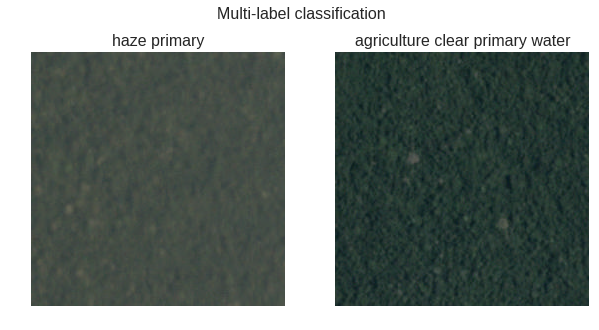

In [22]:
plots_from_files([f for t, f in sample_files], titles=[t for t, f in sample_files], maintitle='Multi-label classification')

This import is from the fastai library, specific to this dataset

In [24]:
from planet import f2

In [25]:
_METRICS = [f2]

In [30]:
_TRAIN_LABELS = os.path.join(_DATA_PATH, 'train_v2.csv')

In [31]:
with open(_TRAIN_LABELS) as f:
    print(f.read())

image_name,tags
train_0,haze primary
train_1,agriculture clear primary water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear habitation primary road
train_5,haze primary water
train_6,agriculture clear cultivation primary water
train_7,haze primary
train_8,agriculture clear cultivation primary
train_9,agriculture clear cultivation primary road
train_10,agriculture clear primary slash_burn water
train_11,clear primary water
train_12,cloudy
train_13,clear primary
train_14,cloudy
train_15,clear primary
train_16,clear primary
train_17,partly_cloudy primary
train_18,clear primary
train_19,agriculture clear primary road
train_20,agriculture clear primary water
train_21,clear primary road water
train_22,partly_cloudy primary
train_23,agriculture clear primary road
train_24,conventional_mine partly_cloudy primary
train_25,clear primary
train_26,cloudy
train_27,agriculture partly_cloudy primary water
train_28,clear primary
train_29,partly_cloudy primary
train_30,clear prim

In [32]:
_TEST_LABELS = os.path.join(_DATA_PATH, 'test_v2_file_mapping.csv')

In [33]:
with open(_TEST_LABELS) as f:
    print(f.read())

old,new
file_4158.tif,file_18830.tif
file_1668.tif,file_19164.tif
file_2411.tif,file_15749.tif
file_16047.tif,file_7531.tif
file_1271.tif,file_18347.tif
file_5652.tif,file_11838.tif
file_15144.tif,file_2349.tif
file_4714.tif,file_7479.tif
file_16364.tif,file_6613.tif
file_4974.tif,file_16062.tif
file_15891.tif,file_10262.tif
file_11356.tif,file_19596.tif
file_20485.tif,file_14408.tif
file_16300.tif,file_4835.tif
file_7609.tif,file_13224.tif
file_14443.tif,file_15748.tif
file_3454.tif,file_6046.tif
file_18736.tif,file_2434.tif
file_15058.tif,file_5116.tif
file_8918.tif,file_17015.tif
file_8429.tif,file_4261.tif
file_11811.tif,file_11085.tif
file_1574.tif,file_12302.tif
file_1868.tif,file_6446.tif
file_8777.tif,file_17499.tif
file_17967.tif,file_2626.tif
file_4982.tif,file_8724.tif
file_7558.tif,file_8212.tif
file_12635.tif,file_333.tif
file_4508.tif,file_11906.tif
file_10153.tif,file_7312.tif
file_3978.tif,file_14437.tif
file_11658.tif,file_4339.tif
file_1763.tif,file_1675.tif
file_3028

Get cross-validation indexes that we'll use during training

In [34]:
_VALIDATION_INDEXES = get_cv_idxs(len(list(open(_TRAIN_LABELS))) - 1)

This function streams training data from the known labels in the csv file and images, with data augmentation applied.

In [36]:
def stream_data_from_csv(model,
                         image_size,
                         data_path,
                         train_subdirectory,
                         test_subdirectory,
                         csv_path,
                         validation_indexes,
                         augmentation_transforms=transforms_top_down,
                         max_zoom=1.05,
                         suffix='.jpg'):
    transforms = tfms_from_model(model,
                                 image_size,
                                 aug_tfms=augmentation_transforms,
                                 max_zoom=max_zoom)
    return ImageClassifierData.from_csv(data_path,
                                        train_subdirectory,
                                        csv_path,
                                        tfms=transforms,
                                        suffix=suffix,
                                        val_idxs=validation_indexes,
                                        test_name=test_subdirectory)

In [39]:
sample_data = stream_data_from_csv(resnet34,
                                   256,
                                   _DATA_PATH,
                                   'train-jpg',
                                   'test-jpg',
                                   _TRAIN_LABELS,
                                   _VALIDATION_INDEXES)

This is what our validation set looks like...

In [41]:
x, y = next(iter(sample_data.val_dl))

In [42]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [44]:
list(zip(sample_data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

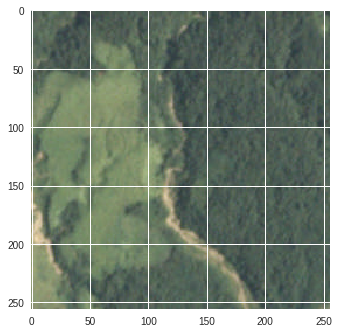

In [46]:
# Note that the image below is typically a bit washed out, so
# we multiply by 1.4 here to brighten it up.
plt.imshow(sample_data.val_ds.denorm(to_np(x))[0] * 1.4)

Lets create a new training data set with 64x64 images

In [67]:
_IMAGE_SIZE = 64
training_data = stream_data_from_csv(resnet34,
                                     _IMAGE_SIZE,
                                     _DATA_PATH,
                                     'train-jpg',
                                     'test-jpg',
                                     _TRAIN_LABELS,
                                     _VALIDATION_INDEXES).resize(int(_IMAGE_SIZE * 1.3), 'tmp')

And use the pretrained model architecture to try and find a learning rate that would work well...


100%|██████████| 506/506 [00:32<00:00, 15.63it/s, loss=0.223]
                                                             [ 0.       0.22293  0.34559  0.78327]



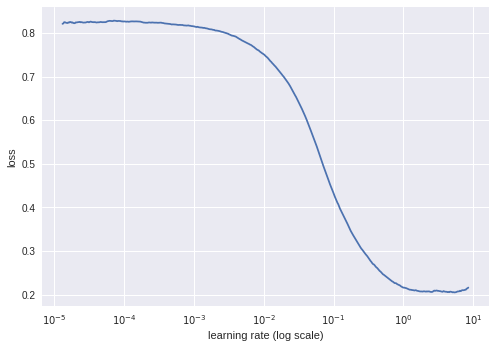

In [53]:
learner = ConvLearner.pretrained(_MODEL_ARCHITECTURE, training_data, metrics=_METRICS)
learning_rate_finder = learner.lr_find()
learner.sched.plot()

0.2 seems to work (notice that it is at a sort of inflection point).

In [54]:
_LEARNING_RATE = 0.2
learner.fit(_LEARNING_RATE, 3, cycle_len=1, cycle_mult=2)

[ 0.       0.14661  0.13511  0.88043]                        
[ 1.       0.1398   0.12968  0.88537]                        
[ 2.       0.13282  0.12883  0.88501]                        
[ 3.       0.13861  0.12766  0.88688]                        
[ 4.       0.13481  0.12671  0.88655]                        
[ 5.       0.13022  0.12507  0.88963]                        
[ 6.       0.12989  0.12476  0.88943]                        



Now that we've fit the dense layers of the model, we can use simulated annealing with restarts to train the other layers. Restarts help to drag us out of local minima, though during training we want to do this less and less. Thus, `cycle_mult` will extent the rate at which the learning rate decreases and thus restarts. 

The reason why we pass an array here is something called *differential learning rates*, which is a way of modifying the rate of training on different layer sets. Since we're training on an entirely new class of images, we're going to have to adjust all the layers to get a better fit, though we need to adjust the convolutional layers slightly less than the max pooling layers and slightly less than the dense layers, since we'll assume that the convolutional layers have at least some things right about general image features. However, these differentials are a lot closer to each other than what we might find in Dog Breeds where our differentials were orders of magnitude apart.

In [55]:
cycling_learning_rates = np.array([_LEARNING_RATE / 9, _LEARNING_RATE / 3, _LEARNING_RATE])
learner.unfreeze()
learner.fit(cycling_learning_rates, 3, cycle_len=1, cycle_mult=3)

[ 0.       0.12008  0.11492  0.90135]                        
[ 1.       0.11049  0.11017  0.90423]                        
[ 2.       0.10722  0.1048   0.9109 ]                        
[ 3.       0.10509  0.10344  0.91111]                        
[ 4.       0.11123  0.10493  0.90869]                        
[ 5.       0.10394  0.10531  0.90834]                        
[ 6.       0.10168  0.10299  0.91215]                        
[ 7.       0.0992   0.10195  0.91446]                         
[ 8.       0.09628  0.10157  0.91253]                         
[ 9.       0.09241  0.10034  0.91335]                         
[ 10.        0.09322   0.09994   0.91426]                     
[ 11.        0.09056   0.10021   0.91462]                     
[ 12.        0.08911   0.09999   0.91498]                     



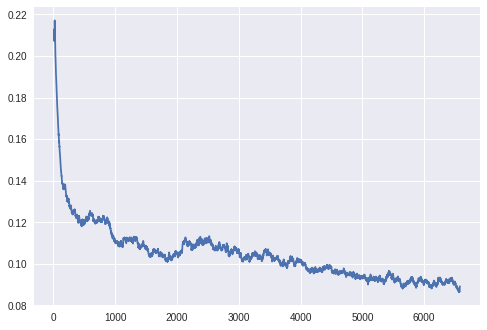

In [56]:
learner.sched.plot_loss()

Now lets try 128x128 images, but not with different learning rates (still with restarts though).

In [58]:
_IMAGE_SIZE = 128
training_data = stream_data_from_csv(resnet34,
                                     _IMAGE_SIZE,
                                     _DATA_PATH,
                                     'train-jpg',
                                     'test-jpg',
                                     _TRAIN_LABELS,
                                     _VALIDATION_INDEXES)
learner.freeze()
learner.set_data(training_data)
learner.fit(_LEARNING_RATE, 3, cycle_len=1, cycle_mult=2)

[ 0.       0.0969   0.09867  0.91629]                         
[ 1.       0.09512  0.09671  0.91647]                         
[ 2.       0.09201  0.09654  0.91769]                         
[ 3.       0.09467  0.09631  0.91781]                         
[ 4.       0.08995  0.09559  0.91842]                         
[ 5.       0.09395  0.09436  0.91996]                         
[ 6.       0.09105  0.09461  0.91891]                         



In [64]:
multiple_predictions, y = learner.TTA()
predictions = np.mean(multiple_predictions, 0)

In [65]:
predictions

array([ 0.30684,  0.00763,  0.02044,  0.00696,  0.00203,  0.70586,  0.04698,  0.00203,  0.10785,  0.08663,
        0.0614 ,  0.18519,  0.93216,  0.20194,  0.00792,  0.00476,  0.17293], dtype=float32)

In [66]:
f2(predictions, y)

ValueError: Found input variables with inconsistent numbers of samples: [8095, 17]